# Lecture 06: Introduction to Dualfoil
---

## Welcome to Dualfoil

[Dualfoil](http://www.cchem.berkeley.edu/jsngrp/fortran.html) is the result of ~30+ years of electrochemical engineering by [John Newman](https://en.wikipedia.org/wiki/John_Newman_(scientist)). 



## What Dualfoil is
In short: Dualfoil is a one-dimensional battery simulation program that models the transport of ions across a battery and imposes butler-volmer type kinetics for reactions, allowing the user to determine what overpotentials will be applied to the open circuit potential of a battery. As Josh Gallaway put so well, "an operating battery is never at steady state", and Dualfoil excels and mapping and tracking the transients. 

Dualfoil works by assuming the that battery is overlapping continuous media of electrode and electrolyte, and  assigns "porosity" via user defined parameter to determine the relative role of each component in the battery. Solid state diffusion is considered via an average particle size. 

For more detailed readings on how this all works, please see

- [Doyle 1993](http://jes.ecsdl.org/content/140/6/1526)
- [Fuller 1994](http://jes.ecsdl.org/content/141/1/1)
- [Fuller 1994](http://jes.ecsdl.org/content/141/4/982)

## What Dualfoil does
Per the [official documentation](http://www.cchem.berkeley.edu/jsngrp/fortran_files/Intro_Dualfoil5.pdf), the "inexperienced user should be able to

>- Change the operating mode and other operating parameters (such as current).
These changes can be made in the input file just beneath the line that specifies
lcurs.  
- Adjust the cell geometrical parameters, such as thicknesses and porosities. These
changes are made in the input file.  
- Modify the initial and ambient temperature, and select whether a run is carried out
isothermally or nonisothermally. Adjust the activation energies. These changes
are made either in the main input file or, in the case of the activation energies, in
the “ebar” input file.  
- Adjust parameters such as the solid-state diffusion coefficients, rate constants for
the main reaction, and solid-phase conductivity to explore the effects of different
types of resistances. These adjustments can all be made in the main input file.
Note that the liquid-phase diffusion coefficient and conductivity are in subroutine
prop; different solvents and electrolytes are chosen in the main input file.  
- Change the materials in the system, including the anode, cathode, and electrolyte.
This is done near the bottom of the input file.  
- Run the system in impedance mode. This is done by changing “imp” from 0 to 1
in the main input file. Note that impedance mode only works with a single
particle, isothermal operation, superposition to calculate solid-state diffusion, and
no side reactions. Also, the mode should be galvanostatic and the current should
be set to zero when running the impedance mode.  
- Input and run the system with a variable diffusion coefficient. Change mvdc1
and/or mvdc3 to 1, and input the desired function and its derivative for the
dependence of the solid-state diffusion coefficient on concentration and
temperature. The functions can be found by searching for the phrase “For a true
variable solid-phase diffusion coefficient.”  
- Add additional materials for which the user has data. The user should change the
appropriate value of nneg, nprop, or npos to “Add your own,” and then input the
appropriate data in subroutine ekin (for a user’s own electrode material) or nprop
(for a user’s own electrolyte).  
- Change the number, size, and fraction of particles in each electrode. For this the
user needs to go to the main code and search for “npa=” Here, the user should
input the number of particles that are desired (from 1 to 5). To use nonuniform
particles, search for “For nonuniform particles use this section” and uncomment
the code in this section. This part of the code is currently set up to model a twoparticle
distribution, and the user should be able to follow this example and read
the comments in this section to make additional changes.  
- (More advanced) Switch from a side reaction framework intended for a NiMH
cell to one for a Li-ion cell. Some changes the user may want to make in this case
are listed here. Change the phase in which the reaction occurs by changing the
volume fractions used in the material balance in equation i7. Change the
stoichiometry of the reaction by changing the value of “sf” in equation i7.
Change the side reaction kinetics to make them appropriate for a side reaction in a
lithium ion system by changing the location of comments in equation i8. 


## What Dualfoil does _not_ do
- Dualfoil will not tell you much about heterogenity within a battery, since it is one dimensional and abstracts the structure of a battery as two superimposed media, or the "macrohomogenous model".
- It will not explicitly predict materials or structuraldegredation, so it will not tell you how the capacity of a battery will fade.
- It will not tell you explicitly when a battery will explode.
- It does not tell you what the system level energy density or power density will be, nor does it model a system. It models an individual cell of a semi-inifite size.

I've created an archive [here](https://github.com/dansteingart/dualfoil5).

I've also made a python wrapper that makes changing parameters within the program a bit easier. Let's walk through that below.


## Using The Dualfoil Simulator

The Dualfoil simulator is a fortran program that takes a textual input file and returns a series of delimited output files that are a schlep to parse. I've done the dirty work and written a wrapper that reads the input file into a python dictionary that you can alter, write out, run the simulation and then read the resultant datasets into a pandas dataframe. Below is an example of how to use it:

first, import what we need

In [1]:
import sys
sys.path.append("/pithy/code")
from pithy import *
import dualfoil
%matplotlib inline

dualfoil and pithy aren't on my python path, so I'm using sys to add them for this script. 

Then, make a dualfoil object. The argument just creates a unique directory for the output files. 

In [2]:
#instantiate simulator
df = dualfoil.dualfoil("user")

These simulations can take a while, and are deterministic (a given input file will always return the same result), so there's no reason to re-run the exact same simulation. The python wrapper saves all of the output files you generate and then checks to see if you've already run a given simulation. If you have it automatically returns the result. If you have not it runs the simulation.

Next, we can decide to change parameters. Below I'm changing the porosity and the electrode thickness.

In [3]:
#specify cell properties
df.parts['ep1'] = .31 #set porosity on reducing electrode
df.parts['h1'] = 100e-6 #set thickness of negative (µm)
df.parts['h3'] = 100e-6 #set thickoness of positive (µm)

The full parameter list is avilable here https://github.com/dansteingart/dualfoil5/blob/master/df5.1/dualfoil5.in

Now we set up the simulated test. Per the settings below I am going to run a common cycle on the battery. All current is current density, in $\frac{A}{m^2}$, time is set in minutes. 

- `df.clear_cycles()` resets the cycling behavior, and should be run before setting a new protocol.  
- `df.set_ocv(x)` sets the battery to rest for x minutes.  
- `df.set_current(y,x,minv=z,maxv=zz)` sets the battery to draw/provide y current for x minutes or until a voltage defined by minv or maxv is hit. minv and maxv are optional, but recommended, parameters.  
- `df.writeout()` writes the parameters to disk.  


In [4]:
#write changes to disk and run simulation
df.clear_cycles()
df.set_ocv(10) #set ocv for 10 minutes
df.set_current(10,10000,minv=3.3) #discharge at 30 A/m^2 for 40 minutes
#df.set_ocv(10) #set ocv for 10 minutes
df.set_current(-10,10000,maxv=4.2) #charge for 40 minutes @ 30 A/m^3df.writeOut()
df.set_ocv(10) #set ocv for 10 minutes
df.writeout()

Now, let's run the simulation. 

- `df.runDualFoil()` will run the simulation with the written parameters. 
  - optional arguments  
    - `debug=True/False` will show extra output regarding the existence of an identical input file
    - `output=True` will show the step state of the simulation
    - `force=True` will force the simulation to run, even if an identical output file exists
    
Below I'm forcing the simulation to run for the sake of this demo, you should omit that flag in your normal usage.

In [5]:
df.runDualFoil(debug=True,output=True,force=True)

Time Difference Between last input and output: 84640.1316359  s
input older than output: analysis is not current: running simulation

   Time     Util N  Util P  Cell Pot   Uocp      Curr      Temp   heatgen
   (min)       x       y      (V)       (V)      (A/m2)    (C)    (W/m2)
   10.033, 0.5999, 0.5001,  4.05069,  4.06260,    10.00,  24.85,   0.12, 
   17.179, 0.5697, 0.5174,  4.02500,  4.04610,    10.00,  24.85,   0.21, 
   45.907, 0.4485, 0.5872,  3.84335,  3.86207,    10.00,  24.85,   0.19, 
   74.634, 0.3273, 0.6569,  3.77074,  3.78981,    10.00,  24.85,   0.19, 
  103.362, 0.2061, 0.7267,  3.68407,  3.70789,    10.00,  24.85,   0.24, 
  146.484, 0.0245, 0.8313,  3.38586,  3.51979,   -10.00,  24.85,  -1.34, 
  146.484, 0.0245, 0.8313,  3.38586,  3.51979,   -10.00,  24.85,  -1.34, 
  153.120, 0.0525, 0.8152,  3.62694,  3.60571,   -10.00,  24.85,   0.21, 
  210.575, 0.2948, 0.6756,  3.78728,  3.77060,   -10.00,  24.85,   0.17, 
  239.303, 0.4160, 0.6059,  3.86126,  3.84293,   -10.

When the simulation is finished, we can read it into a pandas dataframe with 

- `data = df.readoutput()`

You can then interact with the data anyway you want now. I've made a helper function 

- `df.ivtplot()` to plot potential and current vs. time. If you apply the `ir_emph=True` flag it will show the difference between the eq potential and the actual potential.

[0.0, 104.95, -139.18, 0.0] in W*h/kg


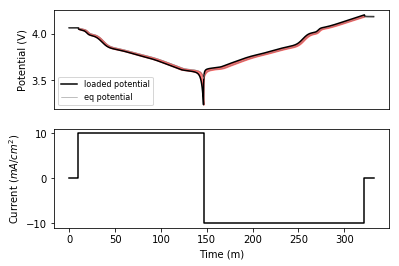

In [6]:
data = df.readoutput() #output of ivt in dataframe format
print data['se'],"in W*h/kg"
df.ivtplot(ir_emph=True)

Below find a simulation run at a much high rate.

Time Difference Between last input and output: 0.807999134064  s
input older than output: analysis is not current: running simulation

   Time     Util N  Util P  Cell Pot   Uocp      Curr      Temp   heatgen
   (min)       x       y      (V)       (V)      (A/m2)    (C)    (W/m2)
   10.033, 0.5972, 0.5016,  3.87552,  4.06117,   200.00,  24.85,  37.11, 
   10.033, 0.5972, 0.5016,  3.87552,  4.06117,   200.00,  24.85,  37.11, 
   13.458, 0.3082, 0.6679,  3.33475,  3.77843,   200.00,  24.85,  85.39, 
   13.458, 0.3082, 0.6679,  3.33475,  3.77843,   200.00,  24.85,  85.39, 
   13.920, 0.2941, 0.6760,  3.88691,  3.77019,  -200.00,  24.85,  30.48, 
   15.780, 0.4483, 0.5873,  4.02190,  3.86188,     0.00,  24.85,   0.49, 
  

mkdir: cannot create directory 'df_user/files/': File exists

[0.0, 54.06, -32.61, 0.0] in W*h/kg


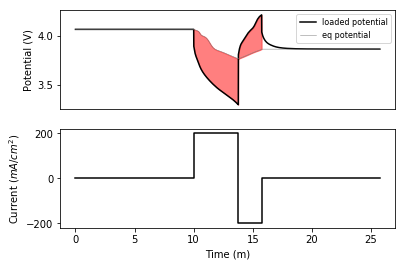

In [7]:
#write changes to disk and run simulation
df.clear_cycles()
df.set_ocv(10) #set ocv for 10 minutes
df.set_current(200,10000,minv=3.3) #discharge at 30 A/m^2 for 40 minutes
#df.set_current(0,10) #set ocv for 10 minutes
df.set_current(-200,10000,maxv=4.2) #charge for 40 minutes @ 30 A/m^3df.writeOut()
df.set_ocv(10) #set ocv for 10 minutes
df.writeOut()
df.runDualFoil(debug=True,output=True,force=True)
data = df.readOutput() #output of ivt in dataframe format
print data['se'],"in W*h/kg"
df.ivtplot(ir_emph=True)